In [ ]:
from google.colab import drive
drive.mount('/content/drive') #akses ke google drive

Mounted at /content/drive


In [ ]:
pip install nltk

In [ ]:
pip install Sastrawi

     |████████████████████████████████| 215kB 30.7MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Train Data
df =  pd.read_excel('/content/drive/My Drive/ml_data/data_fix.xlsx')
print("Data shape:",df.shape)

NegatifDf = df[df["Sentimen"]=="Negatif"].drop("Sentimen",axis=1)
NegatifDf["Sentimen"] = 0

PositifDf = df[df["Sentimen"]=="Positif"].drop("Sentimen",axis=1)
PositifDf["Sentimen"] = 1

df = pd.concat([NegatifDf,PositifDf],ignore_index=True)
print("Final total dataset:",df.shape)

Data shape: (801, 2)
Final total dataset: (801, 2)


In [ ]:
df.head()

,Tweet,Sentimen
0,Saya tergolong yg ga setuju sama cara pemerint...,0
1,"Menurut saya Covid ada, tapi sepertinya elit g...",0
2,"Yups,, egois demi materi... krn RS yg dapat pa...",0
3,Klo kata gw Pemerintah tuh lagi menerapkan Her...,0
4,"Masih bilang beruntung, ribuan warga mati & ba...",0


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop=set(stopwords.words("indonesian"))
stop_bow = set(stopwords.words("indonesian"))
stop_bow.discard("tidak")
factory = StemmerFactory()
stemmer = factory.create_stemmer()

text=df["Tweet"]
cleaned_text_bow=[]
cleaned_text=[]
for line in text:
    tags = re.compile("^@[a-zA-Z_]*")
    line = re.sub(tags," ",line)
    hashtags = re.compile("#|\*")
    extraCharacters = re.compile("[^a-zA-Z]")
    line = re.sub(extraCharacters," ",line)

    filtered_words=[]
    filtered_words_bow=""
    for word in line.split():
        word=word.lower()
        if(word not in stop):
            word = stemmer.stem(word)
            filtered_words.append(word)
        if(word not in stop_bow):
            word = stemmer.stem(word)
            filtered_words_bow+=" "+word
    cleaned_text.append(filtered_words)
    cleaned_text_bow.append(filtered_words_bow)
            
data_bow = pd.DataFrame(data=cleaned_text_bow,columns=["Tweet"])
data_bow["Sentimen"] = df["Sentimen"]
df["Tweet"]=cleaned_text
print(df.head(10))
print()
print(data_bow.head(10))
print()

                                               Tweet  Sentimen
0  [golong, yg, ga, tuju, perintah, tangan, covid...         0
1  [covid, elit, global, main, perintah, masyarak...         0
2  [yups, egois, materi, krn, rs, yg, pasien, cov...         0
3  [klo, gw, perintah, tuh, terap, herd, immunity...         0
4  [bilang, untung, ribu, warga, mati, daftar, ko...         0
5                    [bahaya, covid, perintah, atas]         0
6  [salah, keluarga, menit, tinggal, gara, gara, ...         0
7  [bgmn, turun, masy, bnyk, yg, blm, sadar, peri...         0
8    [perintah, sepele, covid, suruh, damai, dengan]         0
9  [ga, damai, covid, rang, covid, protocol, seha...         0

                                               Tweet  Sentimen
0   golong yg ga tuju perintah tangan covid tp yg...         0
1   covid elit global main perintah masyarakat re...         0
2   yups egois materi krn rs yg pasien covid dpt ...         0
3   klo gw perintah tuh terap herd immunity perin...  

In [ ]:
import gensim
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [ ]:
#Train on text data
list_of_sent = df["Tweet"]
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=4,size=200, workers=4) #size = ukuran vector yg diinginkan, default cbow
w2v_words=list(w2v_model.wv.vocab) #corpus/vocab ambil dr kata yg ada di data train 

In [ ]:
len(w2v_words)

628

In [ ]:
#Vectorize train text data
listof_sent_vec=[]
for sent in tqdm(list_of_sent): 
    sent_vec = np.zeros(200) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    listof_sent_vec.append(sent_vec)
    
Label = df["Sentimen"]
list_col=tuple(range(200))
Scaler = StandardScaler()
data_vec = Scaler.fit_transform(listof_sent_vec)
W2v_data=pd.DataFrame(data=data_vec, columns=list_col)
W2v_data["Sentimen"] = Label
print(W2v_data.head(10))
print(W2v_data.shape)

100%|██████████| 801/801 [00:00<00:00, 5962.76it/s]


          0         1         2  ...       198       199  Sentimen
0 -0.328810  0.451197  0.321221  ...  0.385873 -0.391891         0
1 -0.479761  0.422532  0.341892  ...  0.307157 -0.410719         0
2  0.826173 -0.821553 -0.977794  ... -0.826719  0.831654         0
3  0.824132 -0.866524 -0.846657  ... -0.821906  0.822232         0
4  1.105620 -1.009281 -1.019453  ... -0.996044  1.037623         0
5 -2.395636  2.287532  2.499524  ...  2.240229 -2.290654         0
6 -0.020727  0.084161  0.106876  ...  0.022193 -0.044330         0
7  0.697369 -0.608017 -0.676392  ... -0.681131  0.687687         0
8 -0.694684  0.618592  0.709601  ...  0.647554 -0.640370         0
9  0.196786 -0.226459 -0.282784  ... -0.262442  0.242836         0

[10 rows x 201 columns]
(801, 201)


In [ ]:
X = W2v_data.drop("Sentimen",axis=1).to_numpy()
X

array([[-0.3288095 ,  0.45119742,  0.32122126, ..., -0.3793533 ,
         0.38587329, -0.39189107],
       [-0.47976119,  0.42253236,  0.34189192, ..., -0.39062349,
         0.30715738, -0.41071919],
       [ 0.82617298, -0.82155322, -0.9777943 , ...,  0.81883289,
        -0.82671885,  0.83165388],
       ...,
       [-0.93134891,  1.0116084 ,  0.689677  , ..., -0.98732555,
         1.01467589, -1.00686509],
       [ 1.04422907, -1.15277306, -1.05456428, ...,  1.09812161,
        -1.10226103,  1.08437107],
       [-0.4227972 ,  0.4835249 ,  0.37092194, ..., -0.47867185,
         0.48012208, -0.45717133]])

In [ ]:
y = W2v_data["Sentimen"].to_numpy()
y[0:5]

array([0, 0, 0, 0, 0])

In [ ]:
from sklearn import model_selection, svm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from scipy.sparse import csr_matrix as matrixTransform

In [ ]:
class myClass:
    def __init__(self):
        self.recall = 0
        self.acc = 0
        self.pres = 0
    def getRecall(self):
        return self.recall
    def getPres(self):
        return self.pres
    def setRecall(self, recall):
        self.recall = recall
    def setPres(self, pres):
        self.pres = pres

In [ ]:
def classify2():

    SVM = svm.SVC(C=1, kernel='linear', probability=True)
    SVM.fit(Train_X_final, y_train)
    predictions_SVM = SVM.predict(Test_X_final)

    acc = accuracy_score(predictions_SVM, y_test)
    CM = confusion_matrix(y_test, predictions_SVM)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    try :
        pres = TP/(TP+FP)
    except :
        pres = 0  
    accu = (TP+TN)/(TP+FP+TN+FN)
    recall = TP/(TP+FN)

    acc = accuracy_score(y_test, predictions_SVM)
    recll = recall_score(y_test, predictions_SVM)
    prec = precision_score(y_test, predictions_SVM)
    
    obj.setRecall(recall)
    obj.setPres(pres)
    
    print("Confusion Matrix")
    print(CM)
    return accu

In [ ]:
obj = myClass()
acc_scores = []
presisi_scores = []
recall_scores = []
cv = KFold(n_splits=10, random_state=32, shuffle=True)
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

    Test_X_final = matrixTransform(X_test)
    Train_X_final = matrixTransform(X_train)    
    print("Data Train :", len(X_train))
    print("Data Test :", len(X_test))

    acc= classify2()
    acc_scores.append(acc)
    presisi_scores.append(obj.getPres())
    recall_scores.append(obj.getRecall())

Data Train : 720
Data Test : 81
Confusion Matrix
[[36  9]
 [ 5 31]]
Data Train : 721
Data Test : 80
Confusion Matrix
[[37  6]
 [ 2 35]]
Data Train : 721
Data Test : 80
Confusion Matrix
[[32  9]
 [ 6 33]]
Data Train : 721
Data Test : 80
Confusion Matrix
[[23  7]
 [13 37]]
Data Train : 721
Data Test : 80
Confusion Matrix
[[35  6]
 [ 7 32]]
Data Train : 721
Data Test : 80
Confusion Matrix
[[31  4]
 [10 35]]
Data Train : 721
Data Test : 80
Confusion Matrix
[[34  7]
 [ 6 33]]
Data Train : 721
Data Test : 80
Confusion Matrix
[[29 11]
 [ 8 32]]
Data Train : 721
Data Test : 80
Confusion Matrix
[[36  8]
 [ 6 30]]
Data Train : 721
Data Test : 80
Confusion Matrix
[[33  8]
 [ 7 32]]


In [ ]:
print("Pengujian dengan SVM...")
print("Accuracy :", acc_scores)
print("Presisi :", presisi_scores)
print("Recall :", recall_scores)
print("Accuracy Average :", np.mean(acc_scores))
print("Presisi Average :", np.mean(presisi_scores)) 
print("Recall Average :", np.mean(recall_scores))

Pengujian dengan SVM...
Accuracy : [0.8271604938271605, 0.9, 0.8125, 0.75, 0.8375, 0.825, 0.8375, 0.7625, 0.825, 0.8125]
Presisi : [0.775, 0.8536585365853658, 0.7857142857142857, 0.8409090909090909, 0.8421052631578947, 0.8974358974358975, 0.825, 0.7441860465116279, 0.7894736842105263, 0.8]
Recall : [0.8611111111111112, 0.9459459459459459, 0.8461538461538461, 0.74, 0.8205128205128205, 0.7777777777777778, 0.8461538461538461, 0.8, 0.8333333333333334, 0.8205128205128205]
Accuracy Average : 0.8189660493827162
Presisi Average : 0.8153482804524689
Recall Average : 0.8291501501501501


In [ ]:
SVM = svm.SVC(C=1, kernel='linear', probability=True)
cv = StratifiedKFold(n_splits=10,shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in 

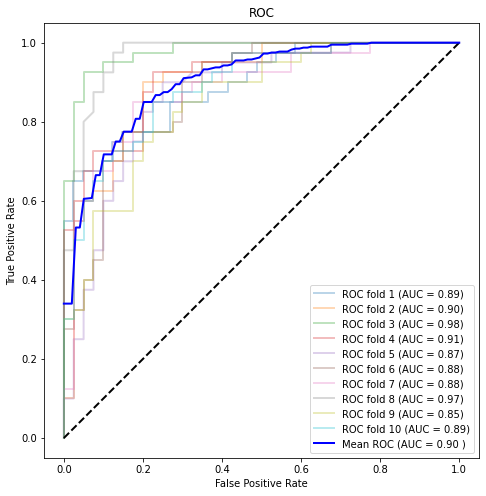

In [ ]:
import matplotlib.pylab as plt
from scipy import interp
from sklearn import model_selection
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.patches as patches

fig1 = plt.figure(figsize=[8,8])
ax1 = fig1.add_subplot(111,aspect = 'equal')
#ax1.add_patch(
#    patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
#    )
#ax1.add_patch(
#    patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
#    )

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(X,y):
    prediction = SVM.fit(X[train],y[train]).predict_proba(X[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
#plt.text(0.32,0.7,'More accurate area',fontsize = 12)
#plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def classify3():

    knn = KNeighborsClassifier(n_neighbors=7, weights="distance", p=2)
    knn.fit(Train_X_final, y_train)
    predictions_KNN = knn.predict(Test_X_final)

    acc = accuracy_score(predictions_KNN, y_test)
    CM = confusion_matrix(y_test, predictions_KNN)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    try :
        pres = TP/(TP+FP)
    except :
        pres = 0  
    accu = (TP+TN)/(TP+FP+TN+FN)
    recall = TP/(TP+FN)

    acc = accuracy_score(y_test, predictions_KNN)
    recll = recall_score(y_test, predictions_KNN)
    prec = precision_score(y_test, predictions_KNN)
    
    obj.setRecall(recall)
    obj.setPres(pres)
    
    print("Confusion Matrix")
    print(CM)
    return accu

In [ ]:
obj = myClass()
acc_scores = []
presisi_scores = []
recall_scores = []
cv = KFold(n_splits=10, random_state=32, shuffle=True)
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

    Test_X_final = matrixTransform(X_test)
    Train_X_final = matrixTransform(X_train)    
    print("Data Train :", len(X_train))
    print("Data Test :", len(X_test))

    acc= classify3()
    acc_scores.append(acc)
    presisi_scores.append(obj.getPres())
    recall_scores.append(obj.getRecall())

In [ ]:
print("Pengujian dengan KNN...")
print("Accuracy :", acc_scores)
print("Presisi :", presisi_scores)
print("Recall :", recall_scores)
print("Accuracy Average :", np.mean(acc_scores))
print("Presisi Average :", np.mean(presisi_scores)) 
print("Recall Average :", np.mean(recall_scores))